# Traditional ML Models - Beat and Rhythm Classification

This notebook trains traditional machine learning models for both beat and rhythm classification tasks:
- **Beat-level classification**: 4 classes (N, S, V, U)
- **Rhythm-level classification**: Multiple rhythm classes
- **Models**: XGBoost, Random Forest, Logistic Regression
- **Data format**: Window-level (60-beat windows, same as DL models)
- **Window parameters**: window_size=60, stride=30 (matching DL models)
- **Data splitting**: Patient-level splits (same as DL models, random_state=42)
- **Model saving**: Trained models saved to `predictions/` folder

## Task Overview
- **Input**: Tabular features extracted from 60-beat windows (HRV features per window)
- **Output**: Multi-class classification predictions at window level
- **Evaluation**: Window-level evaluation for fair comparison with DL models
- **Dataset**: Multiple windows per patient from 482 patients


In [1]:
# Import libraries
import sys
import os
sys.path.append(os.path.abspath('../src'))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
import joblib
from pathlib import Path
import importlib
warnings.filterwarnings('ignore')

# Import our modules
from preprocess import (
    load_all_cases, create_tabular_dataset, create_beat_labels,
    create_rhythm_labels, preprocess_for_ml, split_data_patients,
    calculate_class_weights, create_sequence_dataset,
    BEAT_LABELS, RHYTHM_LABELS
)

# Import feature extraction functions
from feature_extractor import extract_hrv_features, calculate_rr_intervals

from train_models_simple import (
    create_ml_models, train_traditional_ml, evaluate_models_on_test
)

# Import and reload evaluate_models to get latest changes
import evaluate_models
importlib.reload(evaluate_models)
from evaluate_models import (
    evaluate_multi_class, plot_confusion_matrix, plot_per_class_metrics,
    plot_roc_curves_multiclass, create_metrics_comparison_table
)

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("✅ Libraries imported successfully!")
print("✅ evaluate_models module reloaded")
print("🚀 Ready to train traditional ML models")


✅ Libraries imported successfully!
✅ evaluate_models module reloaded
🚀 Ready to train traditional ML models


## Section 1: Data Loading

Load all patient cases from VitalDB Arrhythmia Database.


In [2]:
# Load all cases
print("📂 Loading data...")
annotations_dict, metadata_df = load_all_cases()

print(f"\n✅ Dataset loaded:")
print(f"   Total patients: {len(annotations_dict)}")
print(f"   Total beats: {metadata_df['total_beats'].sum():,}")
print(f"   Total duration: {metadata_df['analyzed_duration_sec'].sum()/3600:.1f} hours")


📂 Loading data...
Filtered 21 samples from 'rhythm_label' (excluded classes: ['Unclassifiable', 'VT'] + NaN)
Filtered 49 samples from 'rhythm_label' (excluded classes: ['Unclassifiable', 'VT'] + NaN)
Filtered 10 samples from 'rhythm_label' (excluded classes: ['Unclassifiable', 'VT'] + NaN)
Filtered 46 samples from 'rhythm_label' (excluded classes: ['Unclassifiable', 'VT'] + NaN)
Filtered 50 samples from 'rhythm_label' (excluded classes: ['Unclassifiable', 'VT'] + NaN)
Filtered 9 samples from 'rhythm_label' (excluded classes: ['Unclassifiable', 'VT'] + NaN)
Filtered 26 samples from 'rhythm_label' (excluded classes: ['Unclassifiable', 'VT'] + NaN)
Filtered 5 samples from 'rhythm_label' (excluded classes: ['Unclassifiable', 'VT'] + NaN)
Filtered 2 samples from 'rhythm_label' (excluded classes: ['Unclassifiable', 'VT'] + NaN)
Filtered 7 samples from 'rhythm_label' (excluded classes: ['Unclassifiable', 'VT'] + NaN)
Filtered 6 samples from 'rhythm_label' (excluded classes: ['Unclassifiable',

## Section 2: Feature Extraction

Extract tabular features and create labels for both tasks.


In [3]:
# ⚠️ WINDOW-LEVEL FEATURE EXTRACTION: Match DL model granularity
# Create same 60-beat windows as DL models (window_size=60, stride=30)
print("📊 Creating 60-beat windows (same as DL models)...")
print("   Window size: 60 beats, Stride: 30 beats\n")

# Create beat classification windows
beat_sequences, beat_window_labels, beat_patient_ids = create_sequence_dataset(
    annotations_dict, metadata_df, window_size=60, stride=30, task='beat'
)

# Create rhythm classification windows
rhythm_sequences, rhythm_window_labels, rhythm_patient_ids = create_sequence_dataset(
    annotations_dict, metadata_df, window_size=60, stride=30, task='rhythm'
)

print(f"\n✅ Windows created:")
print(f"   Beat windows: {len(beat_sequences)} (from {len(set(beat_patient_ids))} patients)")
print(f"   Rhythm windows: {len(rhythm_sequences)} (from {len(set(rhythm_patient_ids))} patients)")

# Helper function to extract features from a window of RR intervals
def extract_window_features(window_rr_intervals, patient_id, window_idx):
    """Extract HRV features from a single window of RR intervals"""
    hrv_features = extract_hrv_features(window_rr_intervals)
    return {
        'case_id': patient_id,
        'window_idx': window_idx,
        **hrv_features
    }

# Extract features from each window for beat classification
print("\n📊 Extracting HRV features from beat windows...")
beat_window_features = []
for i, window_rr in enumerate(beat_sequences):
    features = extract_window_features(window_rr, beat_patient_ids[i], i)
    beat_window_features.append(features)

features_df_beat = pd.DataFrame(beat_window_features)

# Extract features from each window for rhythm classification
print("📊 Extracting HRV features from rhythm windows...")
rhythm_window_features = []
for i, window_rr in enumerate(rhythm_sequences):
    features = extract_window_features(window_rr, rhythm_patient_ids[i], i)
    rhythm_window_features.append(features)

features_df_rhythm = pd.DataFrame(rhythm_window_features)

# Create window-level labels dataframes
beat_labels_df = pd.DataFrame({
    'case_id': beat_patient_ids,
    'window_idx': range(len(beat_patient_ids)),
    'beat_label': beat_window_labels
})

rhythm_labels_df = pd.DataFrame({
    'case_id': rhythm_patient_ids,
    'window_idx': range(len(rhythm_patient_ids)),
    'rhythm_label': rhythm_window_labels
})

print(f"\n✅ Window-level features extracted:")
print(f"   Beat windows: {len(features_df_beat)} windows, {features_df_beat.shape[1]} features per window")
print(f"   Rhythm windows: {len(features_df_rhythm)} windows, {features_df_rhythm.shape[1]} features per window")

# Filter ultra-rare classes in rhythm labels (at window level)
min_support = 5
rhythm_label_counts = rhythm_labels_df['rhythm_label'].value_counts()
rare_classes = rhythm_label_counts[rhythm_label_counts < min_support].index.tolist()
if len(rare_classes) > 0:
    print(f"\n⚠️ Removing ultra-rare rhythm classes (<{min_support} windows): {rare_classes}")
    # Filter windows with rare classes
    mask = ~rhythm_labels_df['rhythm_label'].isin(rare_classes)
    mask_array = mask.values if hasattr(mask, 'values') else np.array(mask)
    
    # Get patient IDs that have ONLY rare classes (to remove from beat windows too)
    # Find patients that have rare class windows
    rare_mask = rhythm_labels_df['rhythm_label'].isin(rare_classes)
    rare_patient_ids = set(rhythm_patient_ids[rare_mask.values if hasattr(rare_mask, 'values') else rare_mask])
    
    # Filter rhythm data
    rhythm_labels_df = rhythm_labels_df[mask].reset_index(drop=True)
    features_df_rhythm = features_df_rhythm[mask].reset_index(drop=True)
    rhythm_patient_ids = rhythm_patient_ids[mask_array]
    
    # Check if any patients now have no windows after filtering
    remaining_rhythm_patients = set(rhythm_patient_ids)
    patients_to_remove = rare_patient_ids - remaining_rhythm_patients
    
    # Also filter corresponding beat windows from patients that were completely removed
    if len(patients_to_remove) > 0:
        beat_mask = ~pd.Series(beat_patient_ids).isin(patients_to_remove)
        beat_labels_df = beat_labels_df[beat_mask].reset_index(drop=True)
        features_df_beat = features_df_beat[beat_mask].reset_index(drop=True)
        beat_patient_ids = beat_patient_ids[beat_mask.values]
        print(f"   Also removed beat windows from {len(patients_to_remove)} patients with only rare rhythms")
    
    print(f"   Removed {len(rare_classes)} rare rhythm classes")
    print(f"   Remaining rhythm classes: {sorted(rhythm_labels_df['rhythm_label'].unique().tolist())}")
    print(f"   Updated rhythm window distribution: {dict(rhythm_labels_df['rhythm_label'].value_counts())}")

print(f"\n🔧 Feature sets for ML models:")
print(f"   Beat classification: {features_df_beat.shape[1]} features per window (HRV features only)")
print(f"   Rhythm classification: {features_df_rhythm.shape[1]} features per window (HRV features only)")
print(f"\n   Beat windows: {len(features_df_beat)}")
print(f"   Rhythm windows: {len(features_df_rhythm)}")
print(f"\n   Beat label distribution: {dict(beat_labels_df['beat_label'].value_counts())}")
print(f"   Rhythm label distribution: {dict(rhythm_labels_df['rhythm_label'].value_counts())}")


📊 Creating 60-beat windows (same as DL models)...
   Window size: 60 beats, Stride: 30 beats

Creating sequence windows (size=60, stride=30)...
✅ Created 21595 windows from 482 patients
Creating sequence windows (size=60, stride=30)...
✅ Created 21603 windows from 482 patients

✅ Windows created:
   Beat windows: 21595 (from 482 patients)
   Rhythm windows: 21603 (from 482 patients)

📊 Extracting HRV features from beat windows...
📊 Extracting HRV features from rhythm windows...

✅ Window-level features extracted:
   Beat windows: 21595 windows, 12 features per window
   Rhythm windows: 21603 windows, 12 features per window

🔧 Feature sets for ML models:
   Beat classification: 12 features per window (HRV features only)
   Rhythm classification: 12 features per window (HRV features only)

   Beat windows: 21595
   Rhythm windows: 21603

   Beat label distribution: {'N': np.int64(15643), 'S': np.int64(5750), 'U': np.int64(185), 'V': np.int64(17)}
   Rhythm label distribution: {'N': np.in

## Section 3: Train/Val/Test Split (Window-Level with Patient-Level Stratification)

Split windows using patient-level splits (same as DL models, random_state=42) to ensure no patient leakage. Windows are split by their patient IDs, maintaining the same 60/20/20 patient distribution as DL models.


In [4]:
# ⚠️ WINDOW-LEVEL SPLITTING: Split windows by patient (no patient leakage)
# DL models split: 60% train, 20% val, 20% test (test_size=0.4 then 0.5 of remaining)
# We'll replicate this exactly by splitting unique patients first, then filtering windows

def split_patients_like_dl(all_case_ids, test_size=0.4, val_size_of_temp=0.5, random_state=42):
    """
    Split patients exactly like DL notebooks do:
    1. Split into train (60%) and temp (40%)
    2. Split temp into val (50% of temp = 20%) and test (50% of temp = 20%)
    Result: 60/20/20 split
    """
    from sklearn.model_selection import train_test_split
    train_patients, temp_patients = train_test_split(
        all_case_ids, test_size=test_size, random_state=random_state
    )
    val_patients, test_patients = train_test_split(
        temp_patients, test_size=val_size_of_temp, random_state=random_state
    )
    return train_patients, val_patients, test_patients

def create_window_splits_from_patients(X_df, y_df, patient_ids_array, train_patients, val_patients, test_patients, scale=True):
    """Create window-level splits from predefined patient lists"""
    import numpy as np
    from sklearn.preprocessing import StandardScaler
    from sklearn.utils.class_weight import compute_class_weight
    
    # Extract numeric features (exclude case_id and window_idx)
    feature_cols = [col for col in X_df.columns if col not in ['case_id', 'window_idx']]
    X = X_df[feature_cols].select_dtypes(include=[np.number])
    
    # Get label column (either 'beat_label' or 'rhythm_label')
    label_col = [col for col in y_df.columns if 'label' in col][0]
    y = y_df[label_col]
    
    # Convert patient_ids_array to pandas Series for easy filtering
    patient_ids_series = pd.Series(patient_ids_array)
    
    # Split windows by patient IDs (ensures no patient leakage)
    train_mask = patient_ids_series.isin(train_patients)
    val_mask = patient_ids_series.isin(val_patients)
    test_mask = patient_ids_series.isin(test_patients)
    
    X_train = X[train_mask].reset_index(drop=True)
    y_train = y[train_mask].reset_index(drop=True)
    ids_train = patient_ids_series[train_mask].reset_index(drop=True)
    
    X_val = X[val_mask].reset_index(drop=True)
    y_val = y[val_mask].reset_index(drop=True)
    ids_val = patient_ids_series[val_mask].reset_index(drop=True)
    
    X_test = X[test_mask].reset_index(drop=True)
    y_test = y[test_mask].reset_index(drop=True)
    ids_test = patient_ids_series[test_mask].reset_index(drop=True)
    
    # Scale if requested
    if scale:
        scaler = StandardScaler()
        X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
        X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns, index=X_val.index)
        X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)
    else:
        scaler = None
    
    splits = {
        'X_train': X_train, 'y_train': y_train, 'ids_train': ids_train,
        'X_val': X_val, 'y_val': y_val, 'ids_val': ids_val,
        'X_test': X_test, 'y_test': y_test, 'ids_test': ids_test
    }
    
    # Calculate class weights (without printing, since we'll print in main cell)
    all_labels = pd.concat([y_train, y_val, y_test])
    unique_classes = sorted(all_labels.unique())
    
    # Calculate class weights manually to avoid duplicate printing
    weights = compute_class_weight('balanced', classes=np.array(unique_classes), y=all_labels)
    class_weights = dict(zip(unique_classes, weights))
    
    print(f"✅ Train/Val/Test split: {len(X_train)}/{len(X_val)}/{len(X_test)} windows")
    print(f"   Windows from {len(ids_train.unique())}/{len(ids_val.unique())}/{len(ids_test.unique())} patients")
    print(f"Class weights: {class_weights}")
    
    return {
        'splits': splits,
        'scaler': scaler,
        'class_weights': class_weights,
        'unique_classes': unique_classes,
        'label_col': label_col
    }

# Get all unique patient IDs from window data
all_beat_patients = np.unique(beat_patient_ids)
all_rhythm_patients = np.unique(rhythm_patient_ids)

# Split patients using DL logic (60/20/20)
beat_train_patients, beat_val_patients, beat_test_patients = split_patients_like_dl(
    all_beat_patients, random_state=42
)
rhythm_train_patients, rhythm_val_patients, rhythm_test_patients = split_patients_like_dl(
    all_rhythm_patients, random_state=42
)

print(f"\n📊 Patient splits (DL-style 60/20/20):")
print(f"   Beat - Train: {len(beat_train_patients)} patients, Val: {len(beat_val_patients)}, Test: {len(beat_test_patients)}")
print(f"   Rhythm - Train: {len(rhythm_train_patients)} patients, Val: {len(rhythm_val_patients)}, Test: {len(rhythm_test_patients)}")

# Create window-level splits for beat classification
print("\n🔄 Creating train/val/test splits for beat classification (window-level, DL-matched patient splits)...")
preprocess_beat = create_window_splits_from_patients(
    features_df_beat, beat_labels_df, beat_patient_ids,
    beat_train_patients, beat_val_patients, beat_test_patients,
    scale=True
)

# Create window-level splits for rhythm classification
print("\n🔄 Creating train/val/test splits for rhythm classification (window-level, DL-matched patient splits)...")
preprocess_rhythm = create_window_splits_from_patients(
    features_df_rhythm, rhythm_labels_df, rhythm_patient_ids,
    rhythm_train_patients, rhythm_val_patients, rhythm_test_patients,
    scale=True
)

splits_beat = preprocess_beat['splits']
splits_rhythm = preprocess_rhythm['splits']

print(f"\n✅ Data splits complete (window-level):")
print(f"   Beat - Train/Val/Test: {len(splits_beat['X_train'])}/{len(splits_beat['X_val'])}/{len(splits_beat['X_test'])} windows")
print(f"   Rhythm - Train/Val/Test: {len(splits_rhythm['X_train'])}/{len(splits_rhythm['X_val'])}/{len(splits_rhythm['X_test'])} windows")

# Store patient IDs for reference
beat_train_ids = splits_beat['ids_train'].unique()
beat_val_ids = splits_beat['ids_val'].unique()
beat_test_ids = splits_beat['ids_test'].unique()

rhythm_train_ids = splits_rhythm['ids_train'].unique()
rhythm_val_ids = splits_rhythm['ids_val'].unique()
rhythm_test_ids = splits_rhythm['ids_test'].unique()

print(f"\n📋 Unique patients per split:")
print(f"   Beat - Train: {len(beat_train_ids)} patients, Val: {len(beat_val_ids)}, Test: {len(beat_test_ids)}")
print(f"   Rhythm - Train: {len(rhythm_train_ids)} patients, Val: {len(rhythm_val_ids)}, Test: {len(rhythm_test_ids)}")



📊 Patient splits (DL-style 60/20/20):
   Beat - Train: 289 patients, Val: 96, Test: 97
   Rhythm - Train: 289 patients, Val: 96, Test: 97

🔄 Creating train/val/test splits for beat classification (window-level, DL-matched patient splits)...
✅ Train/Val/Test split: 12931/4245/4419 windows
   Windows from 289/96/97 patients
Class weights: {'N': np.float64(0.3451224189733427), 'S': np.float64(0.9389130434782609), 'U': np.float64(29.18243243243243), 'V': np.float64(317.5735294117647)}

🔄 Creating train/val/test splits for rhythm classification (window-level, DL-matched patient splits)...
✅ Train/Val/Test split: 12934/4245/4424 windows
   Windows from 289/96/97 patients
Class weights: {'AFIB/AFL': np.float64(0.44950062421972536), 'AVB': np.float64(16.66898148148148), 'MAT': np.float64(7.208208208208208), 'N': np.float64(0.17870260075441732), 'Noise': np.float64(14.459839357429718), 'SND': np.float64(3.230596680125617), 'SR-mPAC-BT': np.float64(4.160023108030041), 'SR-mPVC-BT': np.float64(3

## Section 4: Beat Classification - Train Models


In [5]:
# Create models for beat classification
beat_models = create_ml_models(task_type='beat', num_classes=4, random_state=42)

# Train models
print("🚀 Training beat classification models...")
beat_results = train_traditional_ml(
    beat_models,
    splits_beat['X_train'], splits_beat['y_train'],
    splits_beat['X_val'], splits_beat['y_val'],
    'Beat-Level'
)


🚀 Training beat classification models...

Training Beat-Level Classification Models

Encoded labels: {0: 'N', 1: 'S', 2: 'U', 3: 'V'}

Training XGBoost...
  Train Accuracy: 0.7955
  Val Accuracy: 0.8137

Training RandomForest...
  Train Accuracy: 0.5430
  Val Accuracy: 0.5557

Training LogisticRegression...
  Train Accuracy: 0.7691
  Val Accuracy: 0.8066



In [6]:
# Check for overfitting (train vs val accuracy gap)
print("\n🔍 Overfitting Detection (Window-Level):")
for model_name, result in beat_results.items():
    train_acc = result['train_accuracy']
    val_acc = result['val_accuracy']
    gap = train_acc - val_acc
    status = "⚠️ OVERFITTING!" if gap > 0.15 else "✅ OK" if gap < 0.10 else "⚠️ Monitor"
    print(f"   {model_name}: Train={train_acc:.4f}, Val={val_acc:.4f}, Gap={gap:.4f} {status}")

# Evaluate on test set (window-level evaluation, matching DL models)
beat_results = evaluate_models_on_test(
    beat_results, splits_beat['X_test'], splits_beat['y_test']
)

# Feature importance analysis
print("\n🔍 Feature Importance Analysis (Top 5 features per model):")
for model_name, result in beat_results.items():
    model = result['model']
    # Handle calibrated models - need to get the underlying model
    if hasattr(model, 'base_estimator'):
        base_model = model.base_estimator
    elif hasattr(model, 'estimator'):
        # CalibratedClassifierCV with different structure
        base_model = model.estimator
    else:
        base_model = model
    
    if hasattr(base_model, 'feature_importances_'):
        importances = base_model.feature_importances_
        feature_names = splits_beat['X_train'].columns
        if len(feature_names) == len(importances):
            top_features = pd.DataFrame({
                'feature': feature_names,
                'importance': importances
            }).sort_values('importance', ascending=False)
            print(f"\n{model_name}:")
            print(top_features.head(5).to_string(index=False))
        else:
            print(f"  ⚠️ Feature count mismatch: {len(feature_names)} features vs {len(importances)} importances")
    elif hasattr(base_model, 'coef_'):
        # Logistic Regression
        coef = np.abs(base_model.coef_)
        avg_importance = coef.mean(axis=0) if coef.ndim > 1 else coef
        feature_names = splits_beat['X_train'].columns
        if len(feature_names) == len(avg_importance):
            top_features = pd.DataFrame({
                'feature': feature_names,
                'importance': avg_importance
            }).sort_values('importance', ascending=False)
            print(f"\n{model_name}:")
            print(top_features.head(5).to_string(index=False))
        else:
            print(f"  ⚠️ Feature count mismatch: {len(feature_names)} features vs {len(avg_importance)} coefficients")
    else:
        print(f"  ⚠️ Model does not have feature_importances_ or coef_ attributes")

# Calculate detailed metrics using actual classes from label encoder
beat_metrics = {}
for model_name, result in beat_results.items():
    # Use classes from label encoder if available, otherwise use actual classes in predictions
    if result.get('label_encoder') is not None:
        actual_classes = list(result['label_encoder'].classes_)
    else:
        # Fallback to actual classes in y_test and y_pred
        actual_classes = sorted(list(set(list(splits_beat['y_test']) + list(result['y_test_pred']))))
    
    print(f"\n{model_name} - Using classes: {actual_classes}")
    
    # Get label encoder if available
    label_encoder = result.get('label_encoder')
    
    metrics = evaluate_multi_class(
        splits_beat['y_test'], result['y_test_pred'], result['y_test_proba'],
        actual_classes, f"Beat-{model_name}", label_encoder=label_encoder
    )
    beat_metrics[model_name] = metrics

# Display comparison table
print("\n📊 Beat Classification Results:")
beat_comparison = create_metrics_comparison_table(beat_metrics)
print(beat_comparison.to_string(index=False))



🔍 Overfitting Detection (Window-Level):
   XGBoost: Train=0.7955, Val=0.8137, Gap=-0.0182 ✅ OK
   RandomForest: Train=0.5430, Val=0.5557, Gap=-0.0128 ✅ OK
   LogisticRegression: Train=0.7691, Val=0.8066, Gap=-0.0375 ✅ OK

Evaluating on test set...
XGBoost Test Accuracy: 0.7617
RandomForest Test Accuracy: 0.5343
LogisticRegression Test Accuracy: 0.7508

🔍 Feature Importance Analysis (Top 5 features per model):

XGBoost:
feature  importance
  pnn50    0.257524
  pnn20    0.200413
 std_rr    0.095695
 min_rr    0.086642
 std_hr    0.084588

RandomForest:
feature  importance
  pnn50    0.268810
  pnn20    0.259255
mean_hr    0.129474
 min_rr    0.085082
mean_rr    0.084307

LogisticRegression:
feature  importance
  pnn50    3.190138
  pnn20    1.509060
 std_rr    1.433867
  rmssd    1.406708
 std_hr    1.268310

XGBoost - Using classes: ['N', 'S', 'U', 'V']

RandomForest - Using classes: ['N', 'S', 'U', 'V']

LogisticRegression - Using classes: ['N', 'S', 'U', 'V']

📊 Beat Classification 

## Section 5: Rhythm Classification - Train Models


In [7]:
# Create models for rhythm classification
rhythm_models = create_ml_models(task_type='rhythm', num_classes=11, random_state=42)

# Train models
print("🚀 Training rhythm classification models...")
rhythm_results = train_traditional_ml(
    rhythm_models,
    splits_rhythm['X_train'], splits_rhythm['y_train'],
    splits_rhythm['X_val'], splits_rhythm['y_val'],
    'Rhythm-Level'
)


🚀 Training rhythm classification models...

Training Rhythm-Level Classification Models

Encoded labels: {0: 'AFIB/AFL', 1: 'AVB', 2: 'MAT', 3: 'N', 4: 'Noise', 5: 'SND', 6: 'SR-mPAC-BT', 7: 'SR-mPVC-BT', 8: 'SVTA'}

Training XGBoost...
  Train Accuracy: 0.7633
  Val Accuracy: 0.7366

Training RandomForest...
  Train Accuracy: 0.6178
  Val Accuracy: 0.5920

Training LogisticRegression...
  Train Accuracy: 0.7588
  Val Accuracy: 0.7908



In [8]:
# Check for overfitting (train vs val accuracy gap)
print("\n🔍 Overfitting Detection (Window-Level):")
for model_name, result in rhythm_results.items():
    train_acc = result['train_accuracy']
    val_acc = result['val_accuracy']
    gap = train_acc - val_acc
    status = "⚠️ OVERFITTING!" if gap > 0.15 else "✅ OK" if gap < 0.10 else "⚠️ Monitor"
    print(f"   {model_name}: Train={train_acc:.4f}, Val={val_acc:.4f}, Gap={gap:.4f} {status}")

# Evaluate on test set (window-level evaluation, matching DL models)
rhythm_results = evaluate_models_on_test(
    rhythm_results, splits_rhythm['X_test'], splits_rhythm['y_test']
)

# Feature importance analysis
print("\n🔍 Feature Importance Analysis (Top 5 features per model):")
for model_name, result in rhythm_results.items():
    model = result['model']
    # Handle calibrated models - need to get the underlying model
    if hasattr(model, 'base_estimator'):
        base_model = model.base_estimator
    elif hasattr(model, 'estimator'):
        # CalibratedClassifierCV with different structure
        base_model = model.estimator
    else:
        base_model = model
    
    # Debug: print model type
    print(f"\n{model_name} - Model type: {type(model).__name__}, Base type: {type(base_model).__name__}")
    
    if hasattr(base_model, 'feature_importances_'):
        importances = base_model.feature_importances_
        feature_names = splits_rhythm['X_train'].columns
        if len(feature_names) == len(importances):
            top_features = pd.DataFrame({
                'feature': feature_names,
                'importance': importances
            }).sort_values('importance', ascending=False)
            print(f"\n{model_name}:")
            print(top_features.head(5).to_string(index=False))
        else:
            print(f"  ⚠️ Feature count mismatch: {len(feature_names)} features vs {len(importances)} importances")
    elif hasattr(base_model, 'coef_'):
        # Logistic Regression
        coef = np.abs(base_model.coef_)
        avg_importance = coef.mean(axis=0) if coef.ndim > 1 else coef
        feature_names = splits_rhythm['X_train'].columns
        if len(feature_names) == len(avg_importance):
            top_features = pd.DataFrame({
                'feature': feature_names,
                'importance': avg_importance
            }).sort_values('importance', ascending=False)
            print(f"\n{model_name}:")
            print(top_features.head(5).to_string(index=False))
        else:
            print(f"  ⚠️ Feature count mismatch: {len(feature_names)} features vs {len(avg_importance)} coefficients")
    else:
        print(f"  ⚠️ Model does not have feature_importances_ or coef_ attributes")

# Calculate detailed metrics using actual classes from label encoder
rhythm_metrics = {}
for model_name, result in rhythm_results.items():
    # Use classes from label encoder if available, otherwise use actual classes in predictions
    if result.get('label_encoder') is not None:
        actual_classes = list(result['label_encoder'].classes_)
    else:
        # Fallback to actual classes in y_test and y_pred
        actual_classes = sorted(list(set(list(splits_rhythm['y_test']) + list(result['y_test_pred']))))
    
    print(f"\n{model_name} - Using classes: {actual_classes}")
    
    # Get label encoder if available
    label_encoder = result.get('label_encoder')
    
    metrics = evaluate_multi_class(
        splits_rhythm['y_test'], result['y_test_pred'], result['y_test_proba'],
        actual_classes, f"Rhythm-{model_name}", label_encoder=label_encoder
    )
    rhythm_metrics[model_name] = metrics

# Display comparison table
print("\n📊 Rhythm Classification Results:")
rhythm_comparison = create_metrics_comparison_table(rhythm_metrics)
print(rhythm_comparison.to_string(index=False))



🔍 Overfitting Detection (Window-Level):
   XGBoost: Train=0.7633, Val=0.7366, Gap=0.0266 ✅ OK
   RandomForest: Train=0.6178, Val=0.5920, Gap=0.0258 ✅ OK
   LogisticRegression: Train=0.7588, Val=0.7908, Gap=-0.0320 ✅ OK

Evaluating on test set...
XGBoost Test Accuracy: 0.6508
RandomForest Test Accuracy: 0.5289
LogisticRegression Test Accuracy: 0.7048

🔍 Feature Importance Analysis (Top 5 features per model):

XGBoost - Model type: CalibratedClassifierCV, Base type: XGBClassifier

XGBoost:
 feature  importance
  min_rr    0.121735
   pnn20    0.116745
range_rr    0.115128
   pnn50    0.111065
   rmssd    0.104126

RandomForest - Model type: CalibratedClassifierCV, Base type: RandomForestClassifier

RandomForest:
feature  importance
  rmssd    0.226474
 min_rr    0.133938
  pnn20    0.124626
  pnn50    0.124526
 std_hr    0.074079

LogisticRegression - Model type: CalibratedClassifierCV, Base type: LogisticRegression

LogisticRegression:
feature  importance
  rmssd    2.536765
 std_rr   

## Section 6: Save Models and Predictions

Save trained models using joblib and predictions using pickle to the predictions folder.


In [9]:
# Determine save directory (same logic as DL notebooks)
current_dir = os.getcwd()
if current_dir.endswith('notebooks') or current_dir.endswith('notebooks/'):
    base_dir = os.path.dirname(current_dir)
    save_dir = os.path.join(base_dir, 'experiments', 'results', 'predictions')
elif 'arrdb' in current_dir:
    parts = current_dir.split(os.sep)
    if 'arrdb' in parts:
        arrdb_idx = parts.index('arrdb')
        base_dir = os.sep.join(parts[:arrdb_idx + 1])
        save_dir = os.path.join(base_dir, 'experiments', 'results', 'predictions')
    else:
        save_dir = os.path.join(current_dir, 'experiments', 'results', 'predictions')
else:
    save_dir = os.path.abspath(os.path.join('..', 'experiments', 'results', 'predictions'))

os.makedirs(save_dir, exist_ok=True)
print(f"📁 Save directory: {save_dir}")
print(f"📁 Absolute path: {os.path.abspath(save_dir)}")


📁 Save directory: /home/orlab/GIT_PROJECT/Vital_sign_Dataset/arrdb/experiments/results/predictions
📁 Absolute path: /home/orlab/GIT_PROJECT/Vital_sign_Dataset/arrdb/experiments/results/predictions


In [10]:
# Save beat classification models
print("💾 Saving beat classification models...")
for model_name, result in beat_results.items():
    model = result['model']
    label_encoder = result.get('label_encoder')
    
    # Save model using joblib
    model_filename = os.path.join(save_dir, f'beat_classification_{model_name.lower()}_model.pkl')
    joblib.dump(model, model_filename)
    print(f"   ✅ Saved {model_name} model: {model_filename}")
    
    # Save label encoder if available
    if label_encoder is not None:
        encoder_filename = os.path.join(save_dir, f'beat_classification_{model_name.lower()}_encoder.pkl')
        joblib.dump(label_encoder, encoder_filename)
        print(f"   ✅ Saved {model_name} encoder: {encoder_filename}")

print("\n💾 Saving rhythm classification models...")
for model_name, result in rhythm_results.items():
    model = result['model']
    label_encoder = result.get('label_encoder')
    
    # Save model using joblib
    model_filename = os.path.join(save_dir, f'rhythm_classification_{model_name.lower()}_model.pkl')
    joblib.dump(model, model_filename)
    print(f"   ✅ Saved {model_name} model: {model_filename}")
    
    # Save label encoder if available
    if label_encoder is not None:
        encoder_filename = os.path.join(save_dir, f'rhythm_classification_{model_name.lower()}_encoder.pkl')
        joblib.dump(label_encoder, encoder_filename)
        print(f"   ✅ Saved {model_name} encoder: {encoder_filename}")


💾 Saving beat classification models...
   ✅ Saved XGBoost model: /home/orlab/GIT_PROJECT/Vital_sign_Dataset/arrdb/experiments/results/predictions/beat_classification_xgboost_model.pkl
   ✅ Saved XGBoost encoder: /home/orlab/GIT_PROJECT/Vital_sign_Dataset/arrdb/experiments/results/predictions/beat_classification_xgboost_encoder.pkl
   ✅ Saved RandomForest model: /home/orlab/GIT_PROJECT/Vital_sign_Dataset/arrdb/experiments/results/predictions/beat_classification_randomforest_model.pkl
   ✅ Saved RandomForest encoder: /home/orlab/GIT_PROJECT/Vital_sign_Dataset/arrdb/experiments/results/predictions/beat_classification_randomforest_encoder.pkl
   ✅ Saved LogisticRegression model: /home/orlab/GIT_PROJECT/Vital_sign_Dataset/arrdb/experiments/results/predictions/beat_classification_logisticregression_model.pkl
   ✅ Saved LogisticRegression encoder: /home/orlab/GIT_PROJECT/Vital_sign_Dataset/arrdb/experiments/results/predictions/beat_classification_logisticregression_encoder.pkl

💾 Saving rhyth

In [11]:
# Save predictions for best beat model
best_beat_model = beat_comparison.loc[beat_comparison['Accuracy'].astype(float).idxmax(), 'Model']
best_beat_result = beat_results[best_beat_model]

beat_predictions = {
    'test_pred_str': best_beat_result['y_test_pred'],
    'test_true_str': splits_beat['y_test'],
    'test_proba': best_beat_result['y_test_proba'],
    'X_test': splits_beat['X_test'],  # Save X_test for loading other models
    'label_encoder': best_beat_result.get('label_encoder'),
    'task': 'beat',
    'model_name': best_beat_model,
    'num_classes': len(BEAT_LABELS),
    'class_names': list(BEAT_LABELS),
    'metrics': beat_metrics[best_beat_model]
}

beat_save_path = os.path.join(save_dir, 'beat_classification_ml_predictions.pkl')
with open(beat_save_path, 'wb') as f:
    pickle.dump(beat_predictions, f)
print(f"✅ Saved beat classification predictions to: {beat_save_path}")
print(f"   Model: {best_beat_model}")
print(f"   Accuracy: {beat_metrics[best_beat_model]['accuracy']:.4f}")
if 'auroc_macro' in beat_metrics[best_beat_model]:
    print(f"   AUROC: {beat_metrics[best_beat_model]['auroc_macro']:.4f}")
if 'auprc_macro' in beat_metrics[best_beat_model]:
    print(f"   AUPRC: {beat_metrics[best_beat_model]['auprc_macro']:.4f}")


✅ Saved beat classification predictions to: /home/orlab/GIT_PROJECT/Vital_sign_Dataset/arrdb/experiments/results/predictions/beat_classification_ml_predictions.pkl
   Model: XGBoost
   Accuracy: 0.7617
   AUPRC: 0.4796


In [12]:
# Save predictions for best rhythm model
best_rhythm_model = rhythm_comparison.loc[rhythm_comparison['Accuracy'].astype(float).idxmax(), 'Model']
best_rhythm_result = rhythm_results[best_rhythm_model]

rhythm_predictions = {
    'test_pred_str': best_rhythm_result['y_test_pred'],
    'test_true_str': splits_rhythm['y_test'],
    'test_proba': best_rhythm_result['y_test_proba'],
    'X_test': splits_rhythm['X_test'],  # Save X_test for loading other models
    'label_encoder': best_rhythm_result.get('label_encoder'),
    'task': 'rhythm',
    'model_name': best_rhythm_model,
    'num_classes': len(RHYTHM_LABELS),
    'class_names': list(RHYTHM_LABELS),
    'metrics': rhythm_metrics[best_rhythm_model]
}

rhythm_save_path = os.path.join(save_dir, 'rhythm_classification_ml_predictions.pkl')
with open(rhythm_save_path, 'wb') as f:
    pickle.dump(rhythm_predictions, f)
print(f"✅ Saved rhythm classification predictions to: {rhythm_save_path}")
print(f"   Model: {best_rhythm_model}")
print(f"   Accuracy: {rhythm_metrics[best_rhythm_model]['accuracy']:.4f}")
if 'auroc_macro' in rhythm_metrics[best_rhythm_model]:
    print(f"   AUROC: {rhythm_metrics[best_rhythm_model]['auroc_macro']:.4f}")
if 'auprc_macro' in rhythm_metrics[best_rhythm_model]:
    print(f"   AUPRC: {rhythm_metrics[best_rhythm_model]['auprc_macro']:.4f}")


✅ Saved rhythm classification predictions to: /home/orlab/GIT_PROJECT/Vital_sign_Dataset/arrdb/experiments/results/predictions/rhythm_classification_ml_predictions.pkl
   Model: LogisticRegression
   Accuracy: 0.7048
   AUPRC: 0.3639


## Section 7: Visualizations


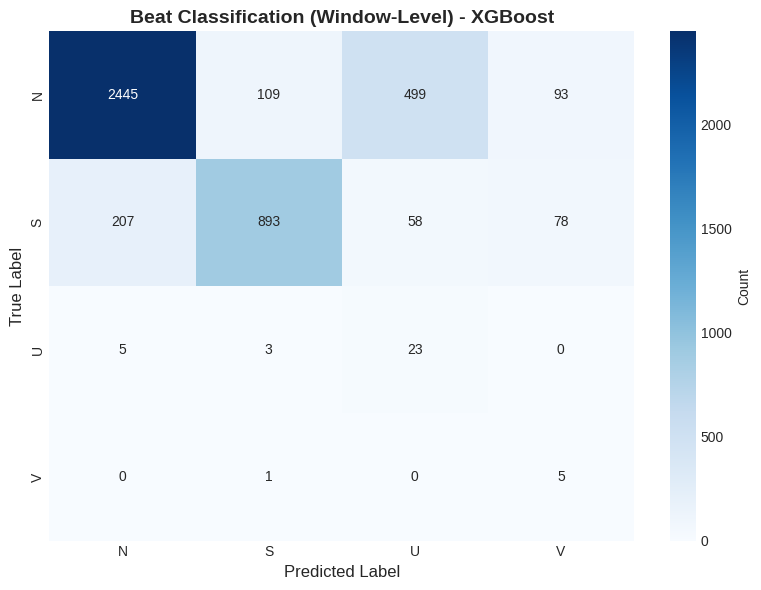

In [13]:
# Plot confusion matrix for best beat model (window-level)
best_beat_model = beat_comparison.loc[beat_comparison['Accuracy'].astype(float).idxmax(), 'Model']
# Use actual classes from metrics (may be filtered)
class_names = beat_metrics[best_beat_model]['class_names']
plot_confusion_matrix(
    beat_metrics[best_beat_model]['confusion_matrix'],
    class_names,
    f'Beat Classification (Window-Level) - {best_beat_model}',
    figsize=(8, 6)
)
plt.show()


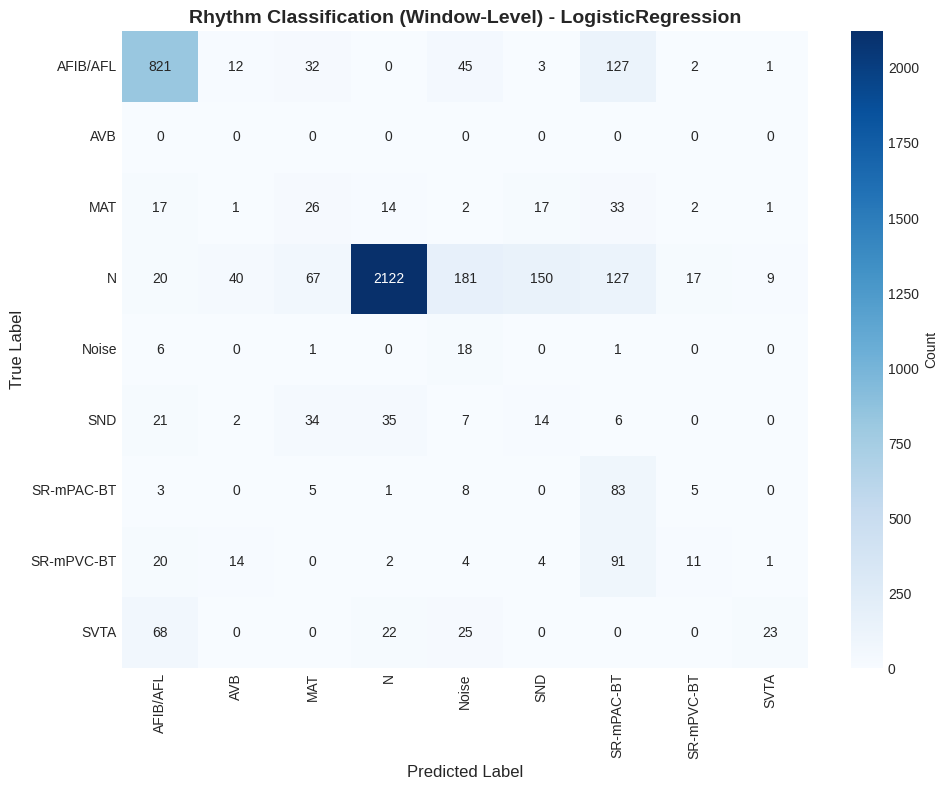

In [14]:
# Plot confusion matrix for best rhythm model (window-level)
best_rhythm_model = rhythm_comparison.loc[rhythm_comparison['Accuracy'].astype(float).idxmax(), 'Model']
# Use actual classes from metrics (may be filtered)
class_names = rhythm_metrics[best_rhythm_model]['class_names']
plot_confusion_matrix(
    rhythm_metrics[best_rhythm_model]['confusion_matrix'],
    class_names,
    f'Rhythm Classification (Window-Level) - {best_rhythm_model}',
    figsize=(10, 8)
)
plt.show()


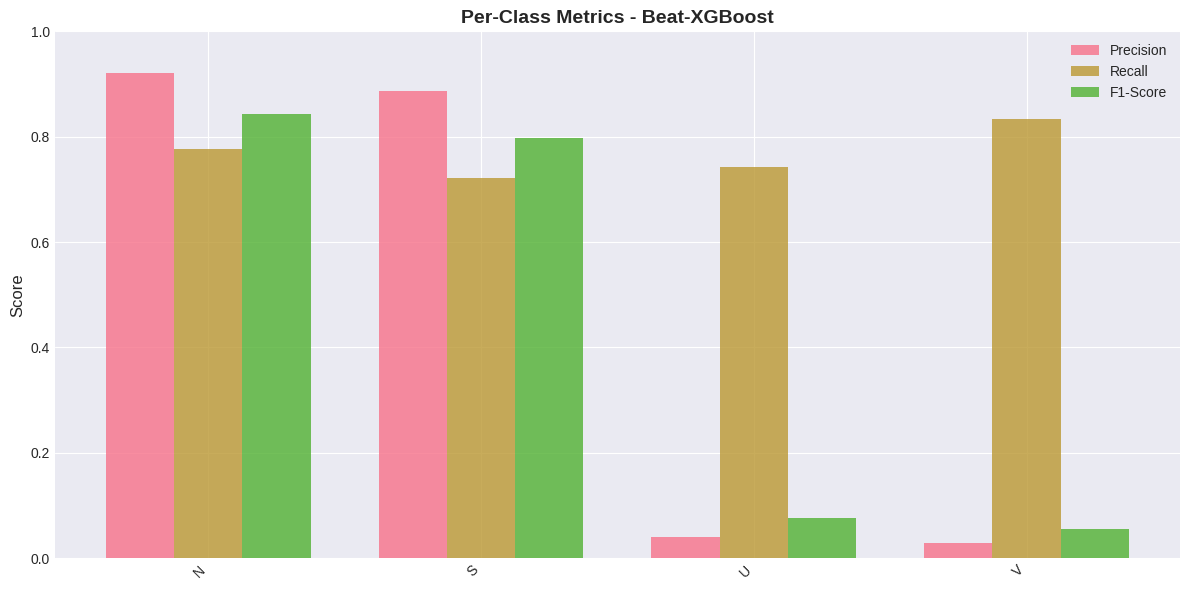

In [15]:
# Plot per-class metrics for beat classification
best_beat_model = beat_comparison.loc[beat_comparison['Accuracy'].astype(float).idxmax(), 'Model']
plot_per_class_metrics(beat_metrics[best_beat_model], figsize=(12, 6))
plt.show()


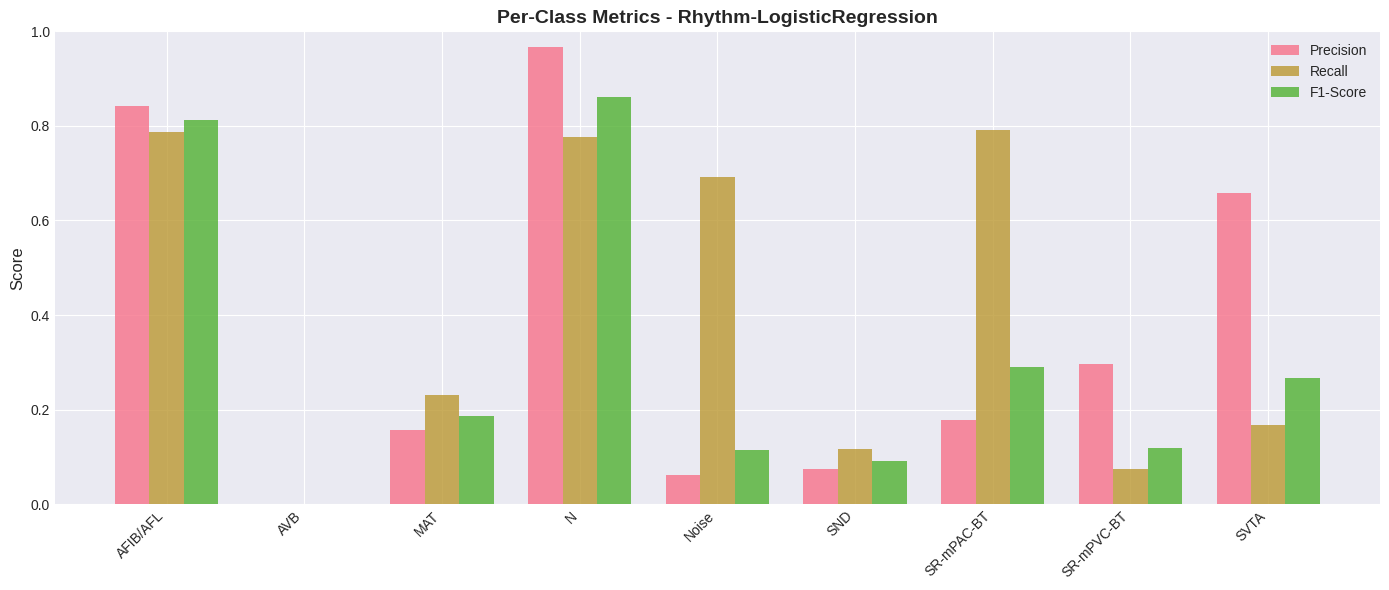

In [16]:
# Plot per-class metrics for rhythm classification
best_rhythm_model = rhythm_comparison.loc[rhythm_comparison['Accuracy'].astype(float).idxmax(), 'Model']
plot_per_class_metrics(rhythm_metrics[best_rhythm_model], figsize=(14, 6))
plt.show()


## Section 8: Summary


In [17]:
print("=" * 70)
print("EXPERIMENT SUMMARY (Window-Level Evaluation)")
print("=" * 70)
print("\n📊 Evaluation Granularity:")
print("   - Both ML and DL models evaluated at WINDOW-LEVEL (60-beat windows)")
print("   - Same windows used: window_size=60, stride=30")
print("   - Same patient splits: 60/20/20 (random_state=42)")
print("   - Fair comparison: Window-level HRV features (ML) vs Raw RR sequences (DL)")
print("\n1. Beat Classification Results (Window-Level):")
print(beat_comparison.to_string(index=False))
print("\n2. Rhythm Classification Results (Window-Level):")
print(rhythm_comparison.to_string(index=False))
print("\n3. Best Models:")
print(f"   - Best Beat Model: {beat_comparison.loc[beat_comparison['Accuracy'].astype(float).idxmax(), 'Model']}")
print(f"   - Best Rhythm Model: {rhythm_comparison.loc[rhythm_comparison['Accuracy'].astype(float).idxmax(), 'Model']}")
print(f"\n4. Saved Models:")
print(f"   - Beat models saved to: {save_dir}/beat_classification_*_model.pkl")
print(f"   - Rhythm models saved to: {save_dir}/rhythm_classification_*_model.pkl")
print(f"   - Predictions saved to: {save_dir}/*_ml_predictions.pkl")
print("\n✅ Experiment complete!")
print("=" * 70)


EXPERIMENT SUMMARY (Window-Level Evaluation)

📊 Evaluation Granularity:
   - Both ML and DL models evaluated at WINDOW-LEVEL (60-beat windows)
   - Same windows used: window_size=60, stride=30
   - Same patient splits: 60/20/20 (random_state=42)
   - Fair comparison: Window-level HRV features (ML) vs Raw RR sequences (DL)

1. Beat Classification Results (Window-Level):
             Model Accuracy Precision (Macro) Recall (Macro) F1 (Macro) Precision (Weighted) Recall (Weighted) F1 (Weighted) AUROC (Macro) AUPRC (Macro)
           XGBoost   0.7617            0.4690         0.7687     0.4424               0.9037            0.7617        0.8233        0.9153        0.4796
      RandomForest   0.5343            0.4329         0.6242     0.3585               0.8647            0.5343        0.6446        0.8428        0.4623
LogisticRegression   0.7508            0.4336         0.5404     0.4149               0.8795            0.7508        0.8058        0.7767        0.4575

2. Rhythm Class